# Advanced Housing Dataset Exploration

1.  Introduction
2.  Exploring the Data
3.  Plotting the Data
4.  Training the Model

Eh, ToC needs work!!

# Introduction


Hello. My name is Evan Freeman. I'm currently just messing around with pandas, matplotlib, and seaborn, and scikit-learn to improve my data analysis and visualization skills. I know this analysis is rather simplistic and makes some arbitrary selections. But I'm primarily focusing on my competence with these libraries, not so much on the optimal data science procedures.

Here we'll be considering the Ames Housing dataset, which is like the Boston Housing dataset, but better!!

## Procedure

1. Split Validation Data (Test data is already seperate, Kaggle will test my model on that data)
  1. 80 / 20 Split
  2. k-fold cross validation
    1. I'll have to rerun the whole pipeline for each fold
    2. I've read that 5 or 10 folds are good. Not sure why exactly those numbers.
2. Visually investigate the data
3.  Feature Generations 
  1. Categorical Parings
  2. Numerical Transformations 
4.  Feature Selection
  1. Principal Component Analysis???
  2. Univariate
  3. Lasso (L1)
  4. Ridge (L2)
5.  Try different models
  1.  Simple Regression
  2.  Random Forest
  3.  XGBoost
  4.  LightGBM
  5.  Neural Net (lol wut)
6.  Hyperparameter Tuning (my fav)
7.  Compare them!

*This is a lie currently, will update someday...

In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
from IPython.display import display
from sklearn.model_selection import train_test_split
from pandas.api.types import is_numeric_dtype
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV as gscv
from sklearn.model_selection import RandomizedSearchCV as rscv
import warnings

warnings.filterwarnings('ignore')

# pd.options.display.max_columns = None
pd.options.display.max_rows = 56


filepath = 'D:/code/Data/house-prices-advanced-regression-techniques/'
sub_filepath = 'D:/code/Data/advanced_housing_submissions/'

housing = pd.read_csv(f'{filepath}train.csv')
test = pd.read_csv(f'{filepath}test.csv')

Note: The test data has already been split for us by Kaggle, but we MUST split off validation data (or do k-fold) as well!!! Otherwise we will overfit.  

Let's split off 20% for validation.  

Later, we'll try with k-fold validation, which should produce better results.  

It is worth pointing out that, once we've trained and validated our model, chosing the best type of model, the best features, the best hyperparameters, we should go back and train it from scratch on the entire dataset (train + valid). If we don't, we're just hamstringing our model by not using all the available data.

Also, we'll create a pipeline for all these steps. For now, we're just exploring.

In [34]:
# Train Valid Split, 80 / 20

train, valid = train_test_split(housing, test_size = .2)

# Also, we're going to need the test ids for submission, so let's grab those

test_id = test['Id']

# Plotting the Data

Before we start processing the data, let's visualize the data and see if we can pick out any interesting information that way.

In [35]:
# # Scatter Plots for all features vs target

# for feature in train.columns:
#     if feature != 'SalePrice':
#         plt.figure(figsize = (10, 10))
#         sns.stripplot(x = feature, y = 'SalePrice', hue = None, data = train)
#         plt.title(f'Sale Price vs {feature}')
#         plt.show()

In [36]:
# # Let's try to do regression only for numerical features vs target

# count = 0

# for feature in train.columns:
#     if is_numeric_dtype(train[feature]) and feature != 'SalePrice':
#         count += 1
#         plt.figure(figsize = (10, 10))
#         plt.title(f'Sale Price vs {feature}')
#         sns.regplot(x = feature, y = 'SalePrice', data = train)
#         plt.show()

Some initial thoughts based on these graphs:
1. Many of these features do not seem correlated with our target. However, we must not forget that there may be interactions between these seemingly irrelevant features which ARE correlated with our target.

# Preprocessing the Data

Before we start selecting and training models, we have to preprocess our data. This includes things like dealing with missing values, encoding categorical features, and scaling the data to a normal range.

In [37]:
display(train)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
501,502,60,FV,75.0,9803,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,226700
1123,1124,20,RL,50.0,9405,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2009,WD,Normal,118000
1435,1436,20,RL,80.0,8400,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,NaN,0,7,2008,COD,Abnorml,174000
882,883,60,RL,NaN,9636,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,12,2009,WD,Normal,178000
130,131,60,RL,88.0,14200,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,NaN,0,5,2006,WD,Normal,226000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
538,539,20,RL,NaN,11553,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2006,WD,Normal,158000
1376,1377,30,RL,52.0,6292,Pave,NaN,Reg,Bnk,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Normal,91000
122,123,20,RL,75.0,9464,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,136000
1140,1141,20,RL,60.0,7350,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2008,COD,Abnorml,139000


In [38]:
display(train.columns)

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [39]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1168.000000,1168.000000,966.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1162.000000,1168.000000,...,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000
mean,725.247432,57.166096,69.263975,10604.008562,6.101027,5.561644,1971.023116,1984.659247,102.400172,449.224315,...,93.035103,46.535103,22.545377,2.749144,15.703767,1.357877,35.582192,6.235445,2007.792808,181036.069349
std,420.188485,42.313351,22.411823,10843.608589,1.379268,1.122170,30.433520,20.791378,180.866888,438.250693,...,124.043955,66.574031,61.893817,25.826053,57.880869,26.787053,310.657048,2.684535,1.327276,79457.819749
min,3.000000,20.000000,21.000000,1477.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,58.000000,7500.000000,5.000000,5.000000,1953.000000,1966.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,130437.500000
50%,718.500000,50.000000,69.000000,9468.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,390.000000,...,0.000000,25.500000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,162950.000000
75%,1087.250000,70.000000,80.000000,11532.750000,7.000000,6.000000,2000.000000,2004.000000,161.750000,732.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,213625.000000
max,1459.000000,190.000000,182.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,2260.000000,...,857.000000,547.000000,552.000000,407.000000,480.000000,555.000000,8300.000000,12.000000,2010.000000,755000.000000


## Dealing with missing values

We have a number of choices for dealing with missing values. Let's begin by dropping features which are missing a lot of data (15% or more).

We have to drop from valid, train, and test sets. ONLY USE THE INFO FROM THE TRAIN TO MAKE THE DROPS.

In [40]:
train_null = train.isnull()
train_null_sum = train_null[train_null.columns[train_null.sum() > len(train) * .15]].sum()
display(train_null_sum)
print('')
display(train.columns[train.isnull().sum() > len(train) * .15])
print('')
display(train[train.columns[train.isnull().sum() > len(train) * .15]])

LotFrontage     202
Alley          1094
FireplaceQu     549
PoolQC         1165
Fence           944
MiscFeature    1124
dtype: int64

Index(['LotFrontage', 'Alley', 'FireplaceQu', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

,LotFrontage,Alley,FireplaceQu,PoolQC,Fence,MiscFeature
501,75.0,NaN,NaN,NaN,NaN,NaN
1123,50.0,NaN,NaN,NaN,NaN,NaN
1435,80.0,NaN,Gd,NaN,GdPrv,NaN
882,NaN,NaN,TA,NaN,MnPrv,NaN
130,88.0,NaN,Gd,NaN,GdPrv,NaN
...,...,...,...,...,...,...
538,NaN,NaN,Fa,NaN,NaN,NaN
1376,52.0,NaN,NaN,NaN,NaN,NaN
122,75.0,NaN,NaN,NaN,NaN,NaN
1140,60.0,NaN,NaN,NaN,NaN,NaN


All of these features seem peripheral, and not useful to our model, so let's just drop them.

In [41]:
columns_to_drop = train.loc[:, train.isnull().sum() > len(train) * .15].columns
display(columns_to_drop)
train.drop(columns_to_drop, inplace = True, axis = 1)
valid.drop(columns_to_drop, inplace = True, axis = 1)
test.drop(columns_to_drop, inplace = True, axis = 1)
display(train)
display(valid)
display(test)

Index(['LotFrontage', 'Alley', 'FireplaceQu', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
501,502,60,FV,9803,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,226700
1123,1124,20,RL,9405,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,6,2009,WD,Normal,118000
1435,1436,20,RL,8400,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,7,2008,COD,Abnorml,174000
882,883,60,RL,9636,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,0,0,12,2009,WD,Normal,178000
130,131,60,RL,14200,Pave,Reg,Lvl,AllPub,Corner,Gtl,...,0,0,0,0,0,5,2006,WD,Normal,226000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
538,539,20,RL,11553,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,7,2006,WD,Normal,158000
1376,1377,30,RL,6292,Pave,Reg,Bnk,AllPub,Inside,Gtl,...,0,0,0,0,0,4,2008,WD,Normal,91000
122,123,20,RL,9464,Pave,Reg,Lvl,AllPub,Corner,Gtl,...,0,0,130,0,0,6,2008,WD,Normal,136000
1140,1141,20,RL,7350,Pave,Reg,Lvl,AllPub,Corner,Gtl,...,0,0,0,0,0,6,2008,COD,Abnorml,139000


,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1167,1168,60,RL,10852,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2006,WD,Normal,173000
316,317,60,RL,13005,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,0,0,8,2009,WD,Normal,260000
1383,1384,30,RL,25339,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,112,0,0,0,0,8,2007,WD,Normal,112000
703,704,190,RM,7630,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,40,0,0,0,0,5,2010,WD,Normal,140000
1105,1106,60,RL,12256,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,0,0,4,2010,WD,Normal,325000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,147,30,RM,6120,Pave,Reg,Lvl,AllPub,Corner,Gtl,...,0,0,0,0,0,11,2009,WD,Normal,105000
909,910,60,RL,12589,Pave,IR2,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,6,2009,WD,Normal,174000
289,290,70,RL,8730,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,259,0,0,7,2007,WD,Normal,153575
154,155,30,RM,11340,Pave,Reg,Lvl,AllPub,Corner,Gtl,...,228,0,0,0,0,3,2006,WD,Family,125000


,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,120,0,0,6,2010,WD,Normal
1,1462,20,RL,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,36,0,0,0,0,12500,6,2010,WD,Normal
2,1463,60,RL,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,34,0,0,0,0,0,3,2010,WD,Normal
3,1464,60,RL,9978,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,36,0,0,0,0,0,6,2010,WD,Normal
4,1465,120,RL,5005,Pave,IR1,HLS,AllPub,Inside,Gtl,...,82,0,0,144,0,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,1936,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,0,6,2006,WD,Normal
1455,2916,160,RM,1894,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,24,0,0,0,0,0,4,2006,WD,Abnorml
1456,2917,20,RL,20000,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,0,9,2006,WD,Abnorml
1457,2918,85,RL,10441,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,32,0,0,0,0,700,7,2006,WD,Normal


That was a good start, but we still have a lot of missing values throughout our data. Let's do simple imputting for the rest, with median for numerical features and mode for categorical features. sklearn has a great function for this built in.

In [42]:
num_columns = train.select_dtypes(exclude=['object']).columns
cat_columns = train.select_dtypes(include=['object']).columns

display(num_columns)
display(cat_columns)

Index(['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')

In [43]:
# Impute Categorical Values
train.loc[:, cat_columns] = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent',verbose=0).fit_transform(train.loc[:, cat_columns])
valid.loc[:, cat_columns] = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent',verbose=0).fit_transform(valid.loc[:, cat_columns])
test.loc[:, cat_columns] = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent',verbose=0).fit_transform(test.loc[:, cat_columns])

# Impute Numerical Values
train.loc[:, num_columns] = SimpleImputer(missing_values = np.nan, strategy = 'mean',verbose=0).fit_transform(train.loc[:, num_columns])
valid.loc[:, num_columns] = SimpleImputer(missing_values = np.nan, strategy = 'mean',verbose=0).fit_transform(valid.loc[:, num_columns])
test.loc[:, num_columns.drop('SalePrice')] = SimpleImputer(missing_values = np.nan, strategy = 'mean',verbose=0).fit_transform(test.loc[:, num_columns.drop('SalePrice')])

## Categorical Features

Let's look at the Categorical Features and decide what to do with them.

In [44]:
train_cat = train.select_dtypes(exclude = [np.number])
display(train_cat)

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
501,FV,Pave,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
1123,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,...,SBrkr,TA,Typ,Attchd,Unf,TA,TA,Y,WD,Normal
1435,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,COD,Abnorml
882,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Gilbert,Norm,Norm,...,SBrkr,TA,Typ,BuiltIn,RFn,TA,TA,Y,WD,Normal
130,RL,Pave,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,Fin,TA,TA,Y,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
538,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,...,SBrkr,TA,Typ,Attchd,Unf,TA,TA,Y,WD,Normal
1376,RL,Pave,Reg,Bnk,AllPub,Inside,Gtl,SWISU,Norm,Norm,...,SBrkr,TA,Typ,Detchd,Unf,Fa,TA,Y,WD,Normal
122,RL,Pave,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,...,SBrkr,TA,Typ,Attchd,Unf,TA,TA,Y,WD,Normal
1140,RL,Pave,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,...,SBrkr,TA,Typ,Detchd,Unf,TA,TA,Y,COD,Abnorml


Many of these variable seem ripe for an ordinal encoding, where we turn each entry into a number, like 0, 1, 2, 3... Note that this is a good idea for categorical features which have some inherent order. But if the feature is not ordered in some sense, then ordinal encoding will confuse the algorithm into believing* there is some inherent order. Certianly there is room for debate on just how ordinal some of these features are.  

*No, machines can't think, I'm just anthropomorphising.

Here's a list of features that seem ordinal to me:  
1. LotShape: How regular or irregular the property is shaped
2. Utilities: Which utilities are available, as a chain of sets, which gives order.
3. LandSlope: How sloped the property is
4. ExterQual: Evaluates the quality of the material on the exterior 
5. ExterCond: Evaluates the present condition of the material on the exterior
6. BsmtQual: Evaluates the height of the basement
7. BsmtCond: Evaluates the general condition of the basement
8. BsmtExposure: Refers to walkout or garden level walls
9. BsmtFinType1: Rating of basement finished area
10. BsmtFinType2: Rating of basement finished area (if multiple types)
11. HeatingQC: Heating quality and condition
12. CentralAir: Central air conditioning
13. Electrical: Electrical system
14. KitchenQual: Kitchen quality
15. Functional: Home functionality (Assume typical unless deductions are warranted)
16. FireplaceQu: Fireplace quality. BUT we already dropped this, as it was missing too many values.
17. GarageFinish: Interior finish of the garage
18. GarageQual: Garage quality
19. GarageCond: Garage condition
20. PavedDrive: Paved driveway
21. PoolQC: Pool quality. But, we already dropped this, as it was missing too many values.
22. Fence Quality. BUT, we already dropped this, as it was missing too many values.

While sklearn has a nice OrdinalEncoder built in, it can't know the real world values of these descriptions (e.g. for Garage Finish we should have Finished > Rough Finished > Unfinished > No Garage, though even here there could be debate about whether No Garage is truly lower than the other options, or just incomparable). Therefore, I will have to manually encode all of these...  

Sigh...

In [45]:
# Here are all our maps
# I'm following the convention of giving the worst value 0, and the best the maximum

lotshape_map = {'Reg':3, 'IR1':2, 'IR2':1, 'IR2':0}
utilities_map = {'AllPub':3, 'NoSewr':2, 'NoSeWa':1, 'ELO':0}
landslope_map = {'Gtl':2, 'Mod':1, 'Sev':0}
exterqual_map = {'Ex':4, 'Gd':3, 'TA':2, 'Fa':1, 'Po':0}
extercond_map = exterqual_map
bsmtqual_map = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0}
bsmtcond_map = bsmtqual_map
bsmtexposure_map = {'Gd':4, 'Av':3, 'Mn':2, 'No':1, 'NA':0}

# BSMTFinType1 is a bit strange, because they throw Rec Room in with all the other assesments. I'll set the two averages equal in value, then scale the rest
bsmtfintype1_map = {'GLQ':5, 'ALQ':4, 'BLQ':3, 'Rec':4, 'LwQ':2, 'Unf':1, 'NA':0}
bsmtfintype2_map = bsmtfintype1_map

heatingqc_map = exterqual_map
centralair_map = {'Y':1, 'N':0}

# Electrical is also weird, as there is a mixed option. I'll just set that to a middle value.
electrical_map = {'SBrkr':3, 'FuseA':2, 'FuseF':1, 'FuseP':0}

kitchenqual_map = exterqual_map
functional_map = {'Typ':7, 'Min1':6, 'Min2':5, 'Mod':4, 'Maj1':3, 'Maj2':2, 'Sev':1, 'Sal':0}
garagefinish_map = {'Fin':3, 'RFn':2, 'Unf':1, 'NA':0}
garagequal_map = bsmtqual_map
garagecond_map = bsmtqual_map
paveddrive_map = {'Y':2, 'P':1, 'N':0}

# Here is a list of the maps I just made, so we can just iterate through them
ordinal_maps = [lotshape_map, utilities_map, landslope_map, exterqual_map, extercond_map, bsmtqual_map, bsmtcond_map, bsmtexposure_map, bsmtfintype1_map, bsmtfintype2_map, heatingqc_map, centralair_map, electrical_map, kitchenqual_map, functional_map, garagefinish_map, garagequal_map, garagecond_map, paveddrive_map]

# Here's our list of columns to map, so we can just iterate through them

ordinal_features = ['LotShape', 'Utilities', 'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive']

In [46]:
for i in range(len(ordinal_maps)):
    train[ordinal_features[i]] = train[ordinal_features[i]].map(ordinal_maps[i])
    valid[ordinal_features[i]] = valid[ordinal_features[i]].map(ordinal_maps[i])
    test[ordinal_features[i]] = test[ordinal_features[i]].map(ordinal_maps[i])

display(train[ordinal_features])
display(valid[ordinal_features])
display(test[ordinal_features])

,LotShape,Utilities,LandSlope,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,GarageFinish,GarageQual,GarageCond,PavedDrive
501,3.0,3,2,3,2,4,3,1,5,1,3,1,3.0,3,7,2,3,3,2
1123,3.0,3,2,2,4,3,3,1,1,1,4,1,3.0,2,7,1,3,3,2
1435,3.0,3,2,3,3,3,3,1,1,1,2,1,3.0,3,7,2,3,3,2
882,2.0,3,2,2,2,4,3,1,1,1,3,1,3.0,2,7,2,3,3,2
130,3.0,3,2,2,2,3,3,1,4,1,4,1,3.0,3,7,3,3,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
538,2.0,3,2,2,2,3,3,1,3,1,2,1,3.0,2,7,1,3,3,2
1376,3.0,3,2,2,2,4,3,2,4,1,2,0,3.0,2,7,1,2,3,2
122,3.0,3,2,2,3,3,3,1,3,1,3,1,3.0,2,7,1,3,3,2
1140,3.0,3,2,2,2,3,3,2,4,1,2,1,3.0,2,7,1,3,3,2


,LotShape,Utilities,LandSlope,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,GarageFinish,GarageQual,GarageCond,PavedDrive
1167,2.0,3,2,2,2,4,3,1,5,1,4,1,3,2,7,3,3,3,2
316,2.0,3,2,3,2,4,3,1,5,1,2,1,3,4,7,2,3,3,2
1383,3.0,3,2,2,3,3,3,1,1,1,4,1,3,3,7,1,3,3,0
703,3.0,3,2,2,3,4,3,1,1,1,3,1,3,3,7,1,3,3,0
1105,2.0,3,2,3,2,5,3,3,5,1,4,1,3,3,7,2,3,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,3.0,3,2,2,2,3,3,1,3,1,2,1,2,2,7,1,2,3,2
909,0.0,3,2,3,2,4,3,1,1,1,4,1,3,3,7,3,3,3,2
289,3.0,3,2,2,2,3,3,1,1,1,4,1,2,2,7,1,3,3,2
154,3.0,3,2,2,2,3,3,1,1,1,2,1,2,2,7,1,2,2,2


,LotShape,Utilities,LandSlope,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,GarageFinish,GarageQual,GarageCond,PavedDrive
0,3.0,3,2,2,2,3,3,1,4,2,2,1,3,2,7,1,3,3,2
1,2.0,3,2,2,2,3,3,1,4,1,2,1,3,3,7,1,3,3,2
2,2.0,3,2,2,2,4,3,1,5,1,3,1,3,2,7,3,3,3,2
3,2.0,3,2,2,2,3,3,1,5,1,4,1,3,3,7,3,3,3,2
4,2.0,3,2,3,2,4,3,1,4,1,4,1,3,3,7,2,3,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,3.0,3,2,2,2,3,3,1,1,1,3,1,3,2,7,1,3,3,2
1455,3.0,3,2,2,2,3,3,1,4,1,2,1,3,2,7,1,3,3,2
1456,3.0,3,2,2,2,3,3,1,4,1,4,1,3,2,7,1,3,3,2
1457,3.0,3,2,2,2,4,3,3,5,1,2,1,3,2,7,1,3,3,2


Ok, let's see what categorical features are left to deal with.

In [47]:
train_cat = train.select_dtypes(exclude = [np.number])
display(train_cat)

,MSZoning,Street,LandContour,LotConfig,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,GarageType,SaleType,SaleCondition
501,FV,Pave,Lvl,Inside,Somerst,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,None,PConc,GasA,Attchd,WD,Normal
1123,RL,Pave,Lvl,Inside,Edwards,Norm,Norm,1Fam,1Story,Hip,CompShg,VinylSd,VinylSd,None,CBlock,GasA,Attchd,WD,Normal
1435,RL,Pave,Lvl,Inside,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,Wd Sdng,Wd Sdng,BrkFace,CBlock,GasA,Attchd,COD,Abnorml
882,RL,Pave,Lvl,Corner,Gilbert,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,None,PConc,GasA,BuiltIn,WD,Normal
130,RL,Pave,Lvl,Corner,NAmes,Norm,Norm,1Fam,2Story,Gable,CompShg,MetalSd,MetalSd,BrkFace,CBlock,GasA,Attchd,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
538,RL,Pave,Lvl,Inside,Sawyer,Norm,Norm,1Fam,1Story,Hip,CompShg,Plywood,Plywood,BrkFace,CBlock,GasA,Attchd,WD,Normal
1376,RL,Pave,Bnk,Inside,SWISU,Norm,Norm,1Fam,1Story,Gable,CompShg,Wd Sdng,Wd Sdng,None,BrkTil,GasA,Detchd,WD,Normal
122,RL,Pave,Lvl,Corner,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,MetalSd,MetalSd,BrkFace,CBlock,GasA,Attchd,WD,Normal
1140,RL,Pave,Lvl,Corner,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,HdBoard,HdBoard,None,CBlock,GasA,Detchd,COD,Abnorml


Honestly, I'm not sure what to do with these features for right now, so let's DROP EM ALL!!!! HAHAHAHAHAHAHAHAHA.

One-Hot would be my next choice, but who has time for that???

In [48]:
cat_columns = train.select_dtypes(include=['object']).columns

display(cat_columns)

train.drop(cat_columns, inplace = True, axis = 1)
valid.drop(cat_columns, inplace = True, axis = 1)
test.drop(cat_columns, inplace = True, axis = 1)

Index(['MSZoning', 'Street', 'LandContour', 'LotConfig', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation',
       'Heating', 'GarageType', 'SaleType', 'SaleCondition'],
      dtype='object')

## Numerical Features

Let's consider the correlation coefficients for each pair of Numerical Features.

,Id,MSSubClass,LotArea,LotShape,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,1.000000,0.015951,-0.051276,0.065234,-0.015316,-0.000748,-0.030828,0.025407,-0.006290,-0.016664,...,-0.030359,-0.016960,-0.011707,-0.034613,0.007033,0.024937,0.034009,0.005452,0.021736,-0.020960
MSSubClass,0.015951,1.000000,-0.131754,0.109479,0.025723,0.029812,0.030751,-0.052623,0.027726,0.048995,...,-0.041216,-0.006231,-0.001678,-0.024560,-0.022686,0.009204,0.034607,-0.004154,-0.012524,-0.093154
LotArea,-0.051276,-0.131754,1.000000,-0.326970,-0.010184,-0.478519,0.085298,-0.001737,0.009922,0.004420,...,0.185477,0.069321,-0.019481,0.022710,0.046948,0.039916,0.058938,0.006991,-0.020674,0.262229
LotShape,0.065234,0.109479,-0.326970,1.000000,0.026004,0.148812,-0.189305,-0.014087,-0.204900,-0.171188,...,-0.190387,-0.088571,0.088188,-0.073840,-0.106378,-0.019865,-0.015817,-0.003894,0.010229,-0.280122
Utilities,-0.015316,0.025723,-0.010184,0.026004,1.000000,-0.006791,0.002145,-0.011440,0.012532,0.037550,...,0.021965,-0.031437,0.010667,0.003117,-0.109943,0.001485,0.003354,0.057113,-0.026636,0.016046
LandSlope,-0.000748,0.029812,-0.478519,0.148812,-0.006791,1.000000,0.049358,-0.013766,0.064996,0.045139,...,-0.113248,0.027743,0.005987,-0.022877,-0.065445,0.011765,-0.000236,0.010379,0.006364,-0.082505
OverallQual,-0.030828,0.030751,0.085298,-0.189305,0.002145,0.049358,1.000000,-0.063819,0.562534,0.549789,...,0.226247,0.292445,-0.112546,0.034607,0.072602,0.083559,-0.050794,0.071792,-0.007747,0.788647
OverallCond,0.025407,-0.052623,-0.001737,-0.014087,-0.011440,-0.013766,-0.063819,1.000000,-0.353487,0.069471,...,-0.007061,-0.022665,0.059358,0.013795,0.046707,-0.039988,0.035219,-0.003542,0.035623,-0.059835
YearBuilt,-0.006290,0.027726,0.009922,-0.204900,0.012532,0.064996,0.562534,-0.353487,1.000000,0.597185,...,0.215077,0.159111,-0.376118,0.047813,-0.045536,-0.010159,-0.041364,0.007705,0.016453,0.515825
YearRemodAdd,-0.016664,0.048995,0.004420,-0.171188,0.037550,0.045139,0.549789,0.069471,0.597185,1.000000,...,0.201420,0.211196,-0.175891,0.041604,-0.044836,0.008574,-0.038593,0.010512,0.057338,0.509348


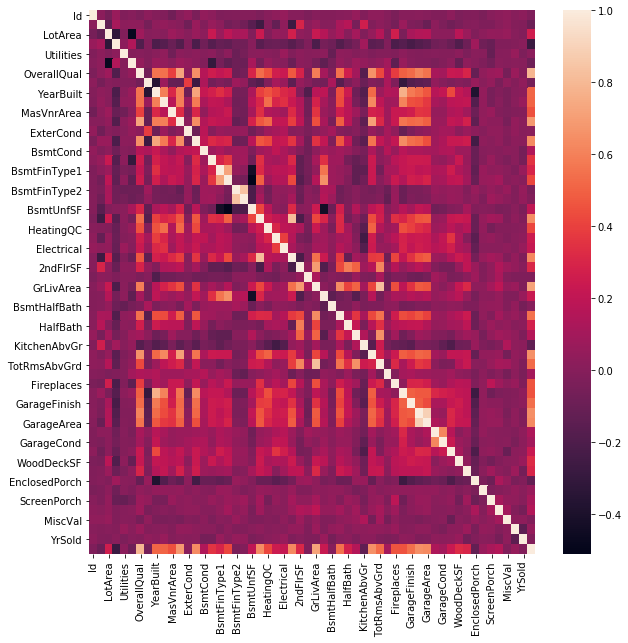

<Figure size 720x720 with 0 Axes>

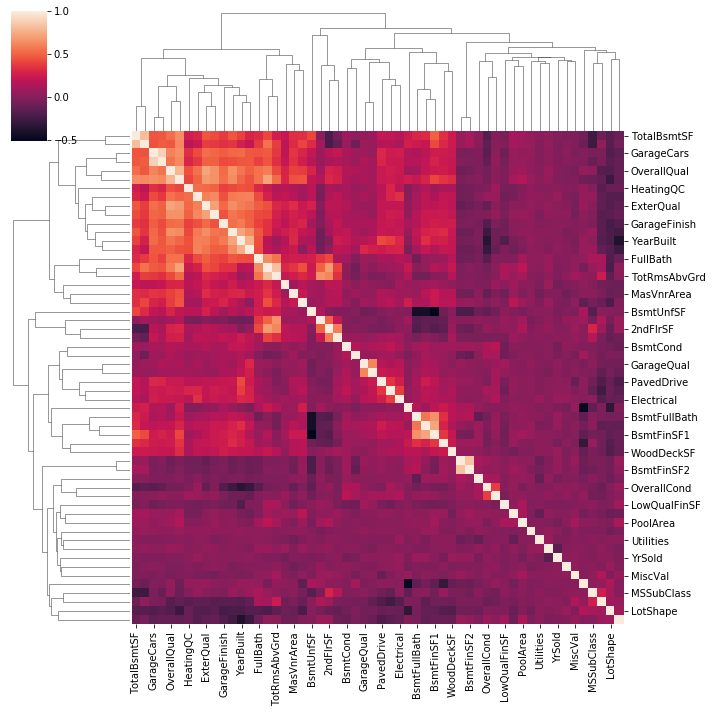

In [49]:
corr = train.corr()
display(corr)

plt.figure(figsize = (10, 10))
sns.heatmap(corr)
plt.show()

plt.figure(figsize = (10, 10))
sns.clustermap(corr)
plt.show()

Interesting. There's a lot more to consider here, but for now let's just focus on numerical features that are highly correlated with our target value.  

Yes, this is a gross simplification. But we'll do multivariate analysis later. I promise!!

In [50]:
display(corr['SalePrice'].sort_values())

LotShape        -0.280122
KitchenAbvGr    -0.131925
EnclosedPorch   -0.122696
MSSubClass      -0.093154
LandSlope       -0.082505
OverallCond     -0.059835
BsmtFinType2    -0.035232
LowQualFinSF    -0.026338
Id              -0.020960
MiscVal         -0.019365
YrSold          -0.011576
BsmtFinSF2      -0.011151
BsmtHalfBath    -0.001182
ExterCond        0.014370
Utilities        0.016046
MoSold           0.050348
3SsnPorch        0.062349
GarageCond       0.099490
Functional       0.106702
ScreenPorch      0.120579
GarageQual       0.134339
BsmtCond         0.149455
PoolArea         0.151545
BedroomAbvGr     0.156530
BsmtUnfSF        0.203427
Electrical       0.223839
BsmtFullBath     0.231287
PavedDrive       0.233903
CentralAir       0.247779
LotArea          0.262229
HalfBath         0.278838
BsmtFinType1     0.296239
OpenPorchSF      0.303372
2ndFlrSF         0.307780
WoodDeckSF       0.322337
BsmtExposure     0.355870
BsmtFinSF1       0.416873
HeatingQC        0.417065
MasVnrArea  

Let's limit our model to just correlation coefficients .5 or above. That will bring us down to 14 numerical features.

In [51]:
corr_sp = corr['SalePrice']

print('')
columns_to_drop = corr_sp.loc[corr_sp < .5].index
display(columns_to_drop)

train.drop(columns_to_drop, inplace = True, axis = 1)
valid.drop(columns_to_drop, inplace = True, axis = 1)
test.drop(columns_to_drop, inplace = True, axis = 1)

Index(['Id', 'MSSubClass', 'LotArea', 'LotShape', 'Utilities', 'LandSlope',
       'OverallCond', 'MasVnrArea', 'ExterCond', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'HeatingQC', 'CentralAir', 'Electrical', '2ndFlrSF', 'LowQualFinSF',
       'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'Functional', 'Fireplaces', 'GarageYrBlt', 'GarageQual',
       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

Now, we need to do some feature scaling!! Normalize this stuff.

For this, and later steps, we'll need to split out our X and y values.

We'll need to reverse transform our predictions before the end, so let's not forget that.

In [52]:
X_train = train.iloc[:, :-1]
y_train = train.iloc[:, -1]

X_valid = valid.iloc[:, :-1]
y_valid = valid.iloc[:, -1]

X_test = test

Ok, now we can scale the data. As always, only fit the the scaler on the TRAIN data, to prevent leakage.

Also, we have to do some reshaping to scale the y values.

Ok, having some trouble with scaling the data. Can't scale the y values for some reason.

I'll work on that later.

In [53]:
# X_scaler = StandardScaler()
# y_scaler = StandardScaler()
# X_scaler.fit(X_train)
# y_scaler.fit(y_train.reshape(-1, 1))

# X_train = X_scaler.transform(X_train)
# X_valid = X_scaler.transform(X_valid)
# X_test = X_scaler.transform(X_test)

# y_train = np.squeeze(y_scaler.transform(y_train.reshape(-1, 1)))
# y_valid = np.squeeze(y_scaler.transform(y_valid.reshape(-1, 1)))

# Training The Model

Now that we're down to a manageable number of features, let's start training and comparing models. We'll start with decision tree, random forest, XGBoost, and LightGBM.

## Decision Tree

In [54]:
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

valid_pred = model.predict(X_valid)
error = np.sqrt(mse(valid_pred, y_valid))
display(f'RMSE for Decision Tree Model is ${error}')

test_pred = model.predict(X_test)

output = pd.DataFrame({'Id': test_id, 'SalePrice': test_pred})

output.to_csv(f'{sub_filepath}advhousesub_decisiontree.csv',index=False, header =1)



'RMSE for Decision Tree Model is $37857.76158046803'

Well, I guess this isn't the worst, but given that the average sale price is 181286.518836, we're looking at about 20% error on average.

Ok, let's upload to Kaggle and compare:

Decision Tree Model got a score of 0.23263, which is substantially worse than our current best of 0.13284  

Our best came from XGBoost and the same procedure as the Kaggle tutorials, plus lots of hyperparameter tuning.

## Random Forest

Everyone knows random forest is way better than simple decision tree!!! Let's put that to the test.

In [55]:
model = RandomForestRegressor()
model.fit(X_train, y_train)

valid_pred = model.predict(X_valid)
error = np.sqrt(mse(valid_pred, y_valid))
display(f'RMSE for Random Forest Model is ${error}')

test_pred = model.predict(X_test)

output = pd.DataFrame({'Id': test_id, 'SalePrice': test_pred})

output.to_csv(f'{sub_filepath}advhousesub_randomforest.csv',index=False, header =1)



'RMSE for Random Forest Model is $29662.718262618713'

Alright, so far we're definitely beating Decision Tree. Let's also sumbit to Kaggle to see how we're doing.

model2 got a score of 0.16133, which is a SUBSTANTIAL improvement over the decision tree. However, it's still a bit worse than our current best of 0.13284  

Our best came from XGBoost and the same procedure as the Kaggle tutorials, plus lots of hyperparameter tuning.


## XGBoost

XGBoost was the hottest model a few years ago. However, it's said to have been surpased by LightGBM these days. Let's find out!!!

Apparently XGBoost is dead on Anaconda. I can't install it. Vive la LightGBM!!!

## LightGBM

Let's test the new hotness.

'RMSE for LightGBM Model is $31913.316420632316'

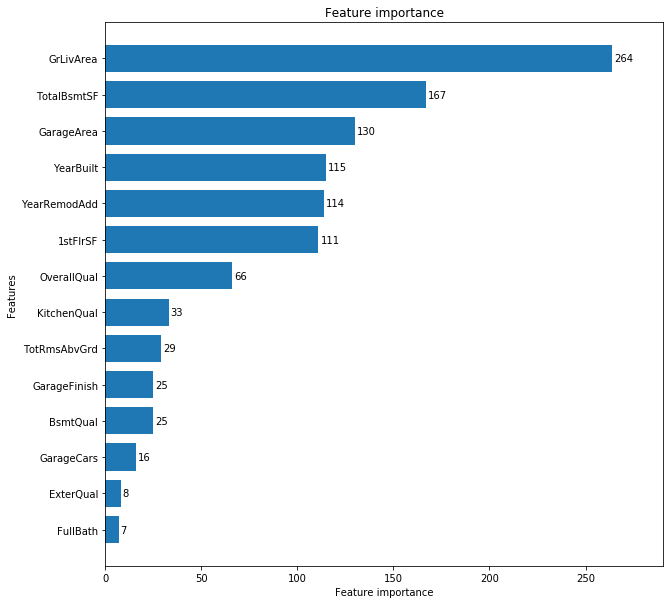

In [56]:
model = lgb.LGBMRegressor()
model.fit(X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            early_stopping_rounds=20, verbose = False)

valid_pred = model.predict(X_valid)
error = np.sqrt(mse(valid_pred, y_valid))

print('')

display(f'RMSE for LightGBM Model is ${error}')

test_pred = model.predict(X_test)

output = pd.DataFrame({'Id': test_id, 'SalePrice': test_pred})

output.to_csv(f'{sub_filepath}advhousesub_lgb.csv',index=False, header =1)

lgb.plot_importance(model, height=.75, figsize = (10, 10), grid = False)
plt.show()



Yay, even better than decision tree. Let's also sumbit to Kaggle to see how we're doing.

model4 got a score of 0.16308, which is slightly worse than decision tree. It's also still a bit worse than our current best of 0.13284  

Our best came from XGBoost and the same procedure as the Kaggle tutorials, plus lots of hyperparameter tuning.

We could likely improve with some hyperparameter tuning, but there are some other big picture improvements we could work on, like:

1.  k-fold validation
2.  Better feature generation and selection
3.  Then maybe some hyperparameter tuning

# LightGBM Big Dump

We've done about all we can with my first preprocessing attempt. Let's see how LightGBM does with minimal preprocessing. Just let it decide what to do. I'm going to call this model the "Big Dump" model, because we're basically just dumping everything into LightGBM and letting it figure out the answer.

In [57]:
housing = pd.read_csv(f'{filepath}train.csv')
test = pd.read_csv(f'{filepath}test.csv')

train, valid = train_test_split(housing, test_size = .2)

In [58]:
# Ok, ordinal encoder doesn't work with NaN values. Crap. Let's do the missing value thing from above first

# Drop heavily empty columns
columns_to_drop = train.columns[train.isnull().sum() > len(train) * .15]
train.drop(columns_to_drop, inplace = True, axis = 1)
valid.drop(columns_to_drop, inplace = True, axis = 1)
test.drop(columns_to_drop, inplace = True, axis = 1)


# Also, drop the IDs
train.drop('Id', inplace = True, axis = 1)
valid.drop('Id', inplace = True, axis = 1)
test.drop('Id', inplace = True, axis = 1)


# Impute the rest

num_columns = train.select_dtypes(exclude=['object']).columns
cat_columns = train.select_dtypes(include=['object']).columns

# Impute Categorical Values
train.loc[:, cat_columns] = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent',verbose=0).fit_transform(train.loc[:, cat_columns])
valid.loc[:, cat_columns] = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent',verbose=0).fit_transform(valid.loc[:, cat_columns])
test.loc[:, cat_columns] = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent',verbose=0).fit_transform(test.loc[:, cat_columns])

# Impute Numerical Values
train.loc[:, num_columns] = SimpleImputer(missing_values = np.nan, strategy = 'mean',verbose=0).fit_transform(train.loc[:, num_columns])
valid.loc[:, num_columns] = SimpleImputer(missing_values = np.nan, strategy = 'mean',verbose=0).fit_transform(valid.loc[:, num_columns])
test.loc[:, num_columns.drop('SalePrice')] = SimpleImputer(missing_values = np.nan, strategy = 'mean',verbose=0).fit_transform(test.loc[:, num_columns.drop('SalePrice')])

In [59]:
#LightGBM says it can handle categorical features without the need for integer or one-hot, but it wasn't doing it for me. Piece of trash.
# LightGBM is supposed to do well with integer encoding, so let's try that
# Was having trouble, so I encoded each seperately, when I really should only encode based on the train data

code = OrdinalEncoder()

train.loc[:, cat_columns] = code.fit_transform(train.loc[:, cat_columns])
valid.loc[:, cat_columns] = code.fit_transform(valid.loc[:, cat_columns])
test.loc[:, cat_columns] = code.fit_transform(test.loc[:, cat_columns])

Ok, now let's try 

In [60]:
X_train = train.iloc[:, :-1]
y_train = train.iloc[:, -1]

X_valid = valid.iloc[:, :-1]
y_valid = valid.iloc[:, -1]

X_test = test

In [61]:
display(X_train)
display(X_valid)
display(X_test)

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
6,20.0,3.0,10084.0,1.0,3.0,3.0,0.0,4.0,0.0,21.0,...,57.0,0.0,0.0,0.0,0.0,0.0,8.0,2007.0,7.0,4.0
1145,50.0,4.0,6240.0,1.0,3.0,3.0,0.0,4.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,8.0,2006.0,7.0,3.0
879,20.0,3.0,7000.0,1.0,0.0,3.0,0.0,1.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,7.0,2009.0,7.0,4.0
293,60.0,3.0,16659.0,1.0,0.0,3.0,0.0,0.0,0.0,14.0,...,250.0,0.0,0.0,0.0,0.0,0.0,3.0,2006.0,7.0,4.0
1278,60.0,3.0,9473.0,1.0,3.0,3.0,0.0,4.0,0.0,5.0,...,211.0,0.0,0.0,0.0,0.0,0.0,3.0,2008.0,7.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,90.0,4.0,9100.0,1.0,3.0,3.0,0.0,4.0,0.0,19.0,...,0.0,0.0,0.0,0.0,0.0,0.0,11.0,2006.0,3.0,0.0
1210,60.0,3.0,11218.0,1.0,3.0,3.0,0.0,4.0,0.0,20.0,...,104.0,0.0,0.0,0.0,0.0,400.0,5.0,2010.0,7.0,4.0
1362,50.0,3.0,12513.0,1.0,0.0,3.0,0.0,2.0,0.0,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6.0,2009.0,7.0,4.0
1032,60.0,3.0,14541.0,1.0,0.0,3.0,0.0,0.0,0.0,15.0,...,55.0,0.0,0.0,0.0,0.0,0.0,11.0,2006.0,7.0,0.0


,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1057,60.0,3.0,29959.0,1.0,1.0,3.0,0.0,2.0,0.0,14.0,...,98.0,0.0,0.0,0.0,0.0,0.0,1.0,2009.0,5.0,3.0
355,20.0,3.0,11249.0,1.0,1.0,3.0,0.0,4.0,0.0,5.0,...,26.0,0.0,0.0,0.0,0.0,0.0,8.0,2007.0,5.0,3.0
616,60.0,3.0,7861.0,1.0,0.0,3.0,0.0,4.0,0.0,8.0,...,75.0,0.0,0.0,0.0,0.0,0.0,6.0,2006.0,5.0,3.0
535,190.0,3.0,7000.0,1.0,3.0,3.0,0.0,4.0,0.0,7.0,...,0.0,148.0,0.0,0.0,0.0,0.0,1.0,2008.0,5.0,3.0
259,20.0,4.0,12702.0,1.0,3.0,3.0,0.0,4.0,0.0,16.0,...,45.0,0.0,0.0,0.0,0.0,0.0,12.0,2008.0,5.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1313,60.0,3.0,14774.0,1.0,0.0,3.0,0.0,0.0,0.0,14.0,...,30.0,0.0,0.0,0.0,0.0,0.0,5.0,2010.0,5.0,3.0
1121,20.0,3.0,10084.0,1.0,3.0,3.0,0.0,4.0,0.0,5.0,...,20.0,0.0,0.0,0.0,0.0,0.0,7.0,2006.0,4.0,4.0
740,70.0,4.0,9600.0,1.0,3.0,3.0,0.0,4.0,0.0,16.0,...,0.0,112.0,0.0,0.0,0.0,0.0,5.0,2007.0,5.0,0.0
747,70.0,4.0,11700.0,1.0,0.0,3.0,0.0,0.0,0.0,16.0,...,0.0,386.0,0.0,0.0,0.0,0.0,5.0,2009.0,5.0,3.0


,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20.0,2.0,11622.0,1.0,3.0,3.0,0.0,4.0,0.0,12.0,...,0.0,0.0,0.0,120.0,0.0,0.0,6.0,2010.0,8.0,4.0
1,20.0,3.0,14267.0,1.0,0.0,3.0,0.0,0.0,0.0,12.0,...,36.0,0.0,0.0,0.0,0.0,12500.0,6.0,2010.0,8.0,4.0
2,60.0,3.0,13830.0,1.0,0.0,3.0,0.0,4.0,0.0,8.0,...,34.0,0.0,0.0,0.0,0.0,0.0,3.0,2010.0,8.0,4.0
3,60.0,3.0,9978.0,1.0,0.0,3.0,0.0,4.0,0.0,8.0,...,36.0,0.0,0.0,0.0,0.0,0.0,6.0,2010.0,8.0,4.0
4,120.0,3.0,5005.0,1.0,0.0,1.0,0.0,4.0,0.0,22.0,...,82.0,0.0,0.0,144.0,0.0,0.0,1.0,2010.0,8.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160.0,4.0,1936.0,1.0,3.0,3.0,0.0,4.0,0.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6.0,2006.0,8.0,4.0
1455,160.0,4.0,1894.0,1.0,3.0,3.0,0.0,4.0,0.0,10.0,...,24.0,0.0,0.0,0.0,0.0,0.0,4.0,2006.0,8.0,0.0
1456,20.0,3.0,20000.0,1.0,3.0,3.0,0.0,4.0,0.0,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,9.0,2006.0,8.0,0.0
1457,85.0,3.0,10441.0,1.0,3.0,3.0,0.0,4.0,0.0,11.0,...,32.0,0.0,0.0,0.0,0.0,700.0,7.0,2006.0,8.0,4.0


In [62]:
model = lgb.LGBMRegressor()
model.fit(X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            early_stopping_rounds=20, verbose = False)

valid_pred = model.predict(X_valid)
error = np.sqrt(mse(valid_pred, y_valid))

print('')

display(f'RMSE for Big Dump LightGBM is ${error}')

test_pred = model.predict(X_test)

output = pd.DataFrame({'Id': test_id, 'SalePrice': test_pred})

output.to_csv(f'{sub_filepath}advhousesub_lgbdump.csv',index=False, header =1)

'RMSE for Big Dump LightGBM is $25039.017202187046'

Well, I've run this a few times, and it keeps changing. Let's kaggle it and see how we do.

Kaggle: .14081
    
Well crap, this is better than even my attempt with all the encoding and stuff. What a waste of time! Still, that's probably because I dropped those other categorical columns.

Let's try tuning this bad boy.

## Grid Search the Big Dump Model

In [63]:
param_test = {'num_leaves': range(50, 60), 
             'learning_rate': [.1],
#              'min_child_samples': range(100, 500), 
#              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
#              'subsample': (.2, .3, .4, .5, .6, .7, .8), 
#              'colsample_bytree': (.2, .3, .4, .5, .6),
#              'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
#              'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]
            }



model = lgb.LGBMRegressor(max_depth=-1, silent=True, n_jobs=4, n_estimators=5000, verbose = -1)



gs = gscv(
            estimator=model, 
            param_grid=param_test, 
            scoring='neg_root_mean_squared_error',
            #cv=5,
            refit=True,
            verbose=True
            )

gs.fit(X_train, y_train, eval_set = [(X_valid, y_valid)], eval_metric = 'rmse', verbose = False, early_stopping_rounds = 30)
print(f'Best score reached: {gs.best_score_} with params: {gs.best_params_} ')

model = lgb.LGBMRegressor(**gs.best_params_)
model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=30, verbose = False)

valid_pred = model.predict(X_valid)
error = np.sqrt(mse(valid_pred, y_valid))

print('')

display(f'RMSE for LightGBM Big Dump Grid Search with parameters {gs.best_params_} is ${error}')

test_pred = model.predict(X_test)

output = pd.DataFrame({'Id': test_id, 'SalePrice': test_pred})

output.to_csv(f'{sub_filepath}advhousesub_lgbdumpgs.csv',index=False, header =1)

lgb.plot_importance(model, height=.75, figsize = (10, 10), grid = False)
plt.show()

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KeyboardInterrupt: 

List of things that performed decently:  

1. learning_rate = .1, num_leaves = 9, early_stopping_rounds = 30, RMSE for model8 is 19088.782686261766'
2. {'early_stopping_rounds': 100, 'learning_rate': 0.01, 'num_leaves': 11}, 'RMSE for model8 is 19088.782686261766'
3. {'learning_rate': 0.01, 'num_leaves': 6, early_stopping rounds = 50}, 'RMSE for model8 is 36324.154902046415'










2. Kaggle: .14039
A little better, still not beating our og. Let's go nuts with hyper tuning.

3. 

Ok, this did eventually give us a decent result, but it's SLOW AS HECK to grid search, and I'm getting bored. Let's RANDOM SEARCH BABY!!!

## Random Search the Big Dump Model

In [ ]:
param_test = {'num_leaves': range(2, 20), 
             'learning_rate': [.01, .02, .03, .04, .05, .06, .07, .08, .09, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1],
              'early_stopping_rounds' : range(10, 200, 10)
#              'min_child_samples': range(100, 500), 
#              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
#              'subsample': (.2, .3, .4, .5, .6, .7, .8), 
#              'colsample_bytree': (.2, .3, .4, .5, .6),
#              'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
#              'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]
            }



model = lgb.LGBMRegressor(max_depth=-1, silent=True, n_jobs=4, n_estimators=5000, verbose = -1)



rs = rscv(
            estimator=model, 
            param_distributions=param_test, 
            scoring='neg_root_mean_squared_error',
            cv=5,
            refit=True,
            verbose=True,
            n_iter = 10
            )

rs.fit(X_train, y_train, eval_set = [(X_valid, y_valid)], eval_metric = 'rmse', verbose = False)

print(f'Best score reached: {rs.best_score_} with params: {rs.best_params_} ')



model = lgb.LGBMRegressor(**rs.best_params_)
model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose = False)

valid_pred = model.predict(X_valid)
error = np.sqrt(mse(valid_pred, y_valid))

print('')

display(f'RMSE for LightGBM Big Dump Random Search with parameters {rs.best_params_} is ${error}')

test_pred = model.predict(X_test)

output = pd.DataFrame({'Id': test_id, 'SalePrice': test_pred})

output.to_csv(f'{sub_filepath}advhousesub_lgbdumprs.csv',index=False, header =1)

lgb.plot_importance(model, height=.75, figsize = (10, 10), grid = False)
plt.show()

List of things that performed decently:  

1. "RMSE for model9 with parameters {'num_leaves': 10, 'learning_rate': 0.02, 'early_stopping_rounds': 180} is 36890.537657012734"
2. "RMSE for model9 with parameters {'num_leaves': 11, 'learning_rate': 0.01, 'early_stopping_rounds': 30} is 47800.831296522185"
3. "RMSE for model9 with parameters {'num_leaves': 8, 'learning_rate': 0.02, 'early_stopping_rounds': 30} is 38031.55374833302"
4. "RMSE for model9 with parameters {'num_leaves': 8, 'learning_rate': 0.2, 'early_stopping_rounds': 10} is 28506.639199674595"
5. "RMSE for model9 with parameters {'num_leaves': 14, 'learning_rate': 0.1, 'early_stopping_rounds': 10} is 28387.987302916474"
6. "RMSE for model9 with parameters {'num_leaves': 15, 'learning_rate': 0.1, 'early_stopping_rounds': 10} is 28320.97315991774
7. "RMSE for model9 with parameters {'num_leaves': 3, 'learning_rate': 0.06, 'early_stopping_rounds': 40} is 36486.701188774045"


List of things that performed decently:  

1. learning_rate = .1, num_leaves = 9, early_stopping_rounds = 30, RMSE for model8 is 19088.782686261766'
2. {'early_stopping_rounds': 100, 'learning_rate': 0.01, 'num_leaves': 11}, 'RMSE for model8 is 19088.782686261766'
3. {'learning_rate': 0.01, 'num_leaves': 6, early_stopping rounds = 50}, 'RMSE for model8 is 36324.154902046415'










2. Kaggle: .14039
A little better, still not beating our og. Let's go nuts with hyper tuning.

3. 

1. Kaggle:

# Reprocessing the Data 1

Let's try some other ways of preprocessing the data.

## Keep everything but very empty columns, use my encoding where possible, otherwise use integer encoding.

In [ ]:
housing = pd.read_csv(f'{filepath}train.csv')
test = pd.read_csv(f'{filepath}test.csv')

train, valid = train_test_split(housing, test_size = .2)

columns_to_drop = train.columns[train.isnull().sum() > len(train) * .15]
train.drop(columns_to_drop, inplace = True, axis = 1)
valid.drop(columns_to_drop, inplace = True, axis = 1)
test.drop(columns_to_drop, inplace = True, axis = 1)

num_columns = train.select_dtypes(exclude=['object']).columns
cat_columns = train.select_dtypes(include=['object']).columns

# Impute Categorical Values
train.loc[:, cat_columns] = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent',verbose=0).fit_transform(train.loc[:, cat_columns])
valid.loc[:, cat_columns] = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent',verbose=0).fit_transform(valid.loc[:, cat_columns])
test.loc[:, cat_columns] = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent',verbose=0).fit_transform(test.loc[:, cat_columns])

# Impute Numerical Values
train.loc[:, num_columns] = SimpleImputer(missing_values = np.nan, strategy = 'mean',verbose=0).fit_transform(train.loc[:, num_columns])
valid.loc[:, num_columns] = SimpleImputer(missing_values = np.nan, strategy = 'mean',verbose=0).fit_transform(valid.loc[:, num_columns])
test.loc[:, num_columns.drop('SalePrice')] = SimpleImputer(missing_values = np.nan, strategy = 'mean',verbose=0).fit_transform(test.loc[:, num_columns.drop('SalePrice')])

lotshape_map = {'Reg':3, 'IR1':2, 'IR2':1, 'IR2':0}
utilities_map = {'AllPub':3, 'NoSewr':2, 'NoSeWa':1, 'ELO':0}
landslope_map = {'Gtl':2, 'Mod':1, 'Sev':0}
exterqual_map = {'Ex':4, 'Gd':3, 'TA':2, 'Fa':1, 'Po':0}
extercond_map = exterqual_map
bsmtqual_map = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0}
bsmtcond_map = bsmtqual_map
bsmtexposure_map = {'Gd':4, 'Av':3, 'Mn':2, 'No':1, 'NA':0}
bsmtfintype1_map = {'GLQ':5, 'ALQ':4, 'BLQ':3, 'Rec':4, 'LwQ':2, 'Unf':1, 'NA':0}
bsmtfintype2_map = bsmtfintype1_map
heatingqc_map = exterqual_map
centralair_map = {'Y':1, 'N':0}
electrical_map = {'SBrkr':3, 'FuseA':2, 'FuseF':1, 'FuseP':0}
kitchenqual_map = exterqual_map
functional_map = {'Typ':7, 'Min1':6, 'Min2':5, 'Mod':4, 'Maj1':3, 'Maj2':2, 'Sev':1, 'Sal':0}
garagefinish_map = {'Fin':3, 'RFn':2, 'Unf':1, 'NA':0}
garagequal_map = bsmtqual_map
garagecond_map = bsmtqual_map
paveddrive_map = {'Y':2, 'P':1, 'N':0}

ordinal_maps = [lotshape_map, utilities_map, landslope_map, exterqual_map, extercond_map, bsmtqual_map, bsmtcond_map, bsmtexposure_map, bsmtfintype1_map, bsmtfintype2_map, heatingqc_map, centralair_map, electrical_map, kitchenqual_map, functional_map, garagefinish_map, garagequal_map, garagecond_map, paveddrive_map]
ordinal_features = ['LotShape', 'Utilities', 'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive']

for i in range(len(ordinal_maps)):
    train[ordinal_features[i]] = train[ordinal_features[i]].map(ordinal_maps[i])
    valid[ordinal_features[i]] = valid[ordinal_features[i]].map(ordinal_maps[i])
    test[ordinal_features[i]] = test[ordinal_features[i]].map(ordinal_maps[i])

cat_columns = train.select_dtypes(include=['object']).columns

In [ ]:
code = OrdinalEncoder()

train.loc[:, cat_columns] = code.fit_transform(train.loc[:, cat_columns])
valid.loc[:, cat_columns] = code.fit_transform(valid.loc[:, cat_columns])
test.loc[:, cat_columns] = code.fit_transform(test.loc[:, cat_columns])

In [ ]:
X_train = train.iloc[:, :-1]
y_train = train.iloc[:, -1]

X_valid = valid.iloc[:, :-1]
y_valid = valid.iloc[:, -1]

X_test = test

model = lgb.LGBMRegressor()
model.fit(X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            early_stopping_rounds=20, verbose = False)

valid_pred = model.predict(X_valid)
error = np.sqrt(mse(valid_pred, y_valid))

print('')

display(f'RMSE for Reprocessed LightGBM is ${error}')

test_pred = model.predict(X_test)

output = pd.DataFrame({'Id': test_id, 'SalePrice': test_pred})

output.to_csv(f'{sub_filepath}advhousesub_reprelgb.csv',index=False, header =1)

lgb.plot_importance(model, height=.75, figsize = (10, 10), grid = False)
plt.show()

lgb._tree_tree_digraph(model)

Holy crap!!! We're down to 22915!!! That's Way freaking better than anything else so far!!!    

Let's see how it perform on Kaggle.

Still not an improvement on Kaggle, though better than anything else we've tried in this kernal.

Kaggle: 0.14104
    
Probably still comes down to preprocessing, but let's try a little hyp tuning and see what we can do. We could also do cross - validation. Oh, and I still need to normalize the data.

## Random Search Preprocessing 1

In [ ]:
param_test = {'num_leaves': range(2, 20), 
             'learning_rate': [.01, .02, .03, .04, .05, .06, .07, .08, .09, .1],
              'early_stopping_rounds' : range(10, 50, 10)
#              'min_child_samples': range(100, 500), 
#              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
#              'subsample': (.2, .3, .4, .5, .6, .7, .8), 
#              'colsample_bytree': (.2, .3, .4, .5, .6),
#              'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
#              'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]
            }



model = lgb.LGBMRegressor(max_depth=-1, silent=True, n_jobs=4, n_estimators=5000, verbose = -1)



rs = rscv(
            estimator=model, 
            param_distributions=param_test, 
            scoring='neg_root_mean_squared_error',
            cv=5,
            refit=True,
            verbose=True,
            n_iter = 10
            )

rs.fit(X_train, y_train, eval_set = [(X_valid, y_valid)], eval_metric = 'rmse', verbose = False)

print(f'Best score reached: {rs.best_score_} with params: {rs.best_params_} ')

model = lgb.LGBMRegressor(**rs.best_params_)
model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose = False)

valid_pred = model.predict(X_valid)
error = np.sqrt(mse(valid_pred, y_valid))

print('')

display(f'RMSE for Repreprocessed LightGBM Random Search with parameters {rs.best_params_} is ${error}')

test_pred = model.predict(X_test)

output = pd.DataFrame({'Id': test_id, 'SalePrice': test_pred})

output.to_csv(f'{sub_filepath}advhousesub_reprelgbrs.csv',index=False, header =1)

lgb.plot_importance(model, height=.75, figsize = (10, 10), grid = False)
plt.show()

List of things that performed decently:  

1. "RMSE for model7 with parameters {'num_leaves': 7, 'learning_rate': 0.1, 'early_stopping_rounds': 30} is 26200.168821416515"
2. "RMSE for model7 with parameters {'num_leaves': 12, 'learning_rate': 0.3, 'early_stopping_rounds': 40} is 35874.30209147329"
3. "RMSE for model7 with parameters {'num_leaves': 9, 'learning_rate': 0.02, 'early_stopping_rounds': 40} is 27146.89532722071"
4. "RMSE for model7 with parameters {'num_leaves': 18, 'learning_rate': 0.08, 'early_stopping_rounds': 40} is 24956.638132730524"

1. Kaggle: 

2. 

# Reprocessing the Data 2

Let's reprocess one more time, with a few changes:
1. No validation set. We'll use the cross validation built into random search to validate our model.
2. One hot encoding for columns that I haven't hand encoded.
3. Train the final model on the whole dataset. Again, no validation split.

## Data Reprocessing 2

In [ ]:
housing = pd.read_csv(f'{filepath}train.csv')
test = pd.read_csv(f'{filepath}test.csv')

train = housing

columns_to_drop = train.columns[train.isnull().sum() > len(train) * .15]
train.drop(columns_to_drop, inplace = True, axis = 1)
test.drop(columns_to_drop, inplace = True, axis = 1)

num_columns = train.select_dtypes(exclude=['object']).columns
cat_columns = train.select_dtypes(include=['object']).columns

# Impute Categorical Values
train.loc[:, cat_columns] = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent',verbose=0).fit_transform(train.loc[:, cat_columns])
test.loc[:, cat_columns] = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent',verbose=0).fit_transform(test.loc[:, cat_columns])

# Impute Numerical Values
train.loc[:, num_columns] = SimpleImputer(missing_values = np.nan, strategy = 'mean',verbose=0).fit_transform(train.loc[:, num_columns])
test.loc[:, num_columns.drop('SalePrice')] = SimpleImputer(missing_values = np.nan, strategy = 'mean',verbose=0).fit_transform(test.loc[:, num_columns.drop('SalePrice')])

lotshape_map = {'Reg':3, 'IR1':2, 'IR2':1, 'IR2':0}
utilities_map = {'AllPub':3, 'NoSewr':2, 'NoSeWa':1, 'ELO':0}
landslope_map = {'Gtl':2, 'Mod':1, 'Sev':0}
exterqual_map = {'Ex':4, 'Gd':3, 'TA':2, 'Fa':1, 'Po':0}
extercond_map = exterqual_map
bsmtqual_map = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0}
bsmtcond_map = bsmtqual_map
bsmtexposure_map = {'Gd':4, 'Av':3, 'Mn':2, 'No':1, 'NA':0}
bsmtfintype1_map = {'GLQ':5, 'ALQ':4, 'BLQ':3, 'Rec':4, 'LwQ':2, 'Unf':1, 'NA':0}
bsmtfintype2_map = bsmtfintype1_map
heatingqc_map = exterqual_map
centralair_map = {'Y':1, 'N':0}
electrical_map = {'SBrkr':3, 'FuseA':2, 'FuseF':1, 'FuseP':0}
kitchenqual_map = exterqual_map
functional_map = {'Typ':7, 'Min1':6, 'Min2':5, 'Mod':4, 'Maj1':3, 'Maj2':2, 'Sev':1, 'Sal':0}
garagefinish_map = {'Fin':3, 'RFn':2, 'Unf':1, 'NA':0}
garagequal_map = bsmtqual_map
garagecond_map = bsmtqual_map
paveddrive_map = {'Y':2, 'P':1, 'N':0}

ordinal_maps = [lotshape_map, utilities_map, landslope_map, exterqual_map, extercond_map, bsmtqual_map, bsmtcond_map, bsmtexposure_map, bsmtfintype1_map, bsmtfintype2_map, heatingqc_map, centralair_map, electrical_map, kitchenqual_map, functional_map, garagefinish_map, garagequal_map, garagecond_map, paveddrive_map]
ordinal_features = ['LotShape', 'Utilities', 'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive']

for i in range(len(ordinal_maps)):
    train[ordinal_features[i]] = train[ordinal_features[i]].map(ordinal_maps[i])
    test[ordinal_features[i]] = test[ordinal_features[i]].map(ordinal_maps[i])

Here's where things get interesting. I think there may be a different number of unique entries for the remaining categorical columns. Which means that when I one-hot, the number of features won't match. Let's check and see.

In [ ]:
cat_columns = train.select_dtypes(include=['object']).columns

for feature in cat_columns:    
    difference = set(train[feature].unique()) - set(test[feature].unique())
    if difference != set():
        display(feature)
        display(difference)

Aha! We've found the culprits! Let's count up how many of each type appear in both train and test, to help us decide what to do with them.

In [ ]:
train.loc[:, cat_columns] = pd.get_dummies(train.loc[:, cat_columns])
test.loc[:, cat_columns] = pd.get_dummies(test.loc[:, cat_columns])

In [ ]:
display(train)

In [ ]:
X_train = train.iloc[:, :-1]
y_train = train.iloc[:, -1]

X_test = test

model = lgb.LGBMRegressor()
model.fit(X_train, y_train, verbose = False)

test_pred = model.predict(X_test)

output = pd.DataFrame({'Id': test_id, 'SalePrice': test_pred})

output.to_csv(f'{sub_filepath}advhousesub_reprelgb2.csv',index=False, header =1)

lgb.plot_importance(model, height=.75, figsize = (10, 10), grid = False)
plt.show()

Holy crap!!! We're down to 22915!!! That's Way freaking better than anything else so far!!!    

Let's see how it perform on Kaggle.

Still not an improvement on Kaggle, though better than anything else we've tried in this kernal.

Kaggle: 0.14104
    
Probably still comes down to preprocessing, but let's try a little hyp tuning and see what we can do. We could also do cross - validation. Oh, and I still need to normalize the data.

## Random Search Preprocessing 2

In [ ]:
param_test = {'num_leaves': range(2, 20), 
             'learning_rate': [.01, .02, .03, .04, .05, .06, .07, .08, .09, .1],
              'early_stopping_rounds' : range(10, 50, 10)
#              'min_child_samples': range(100, 500), 
#              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
#              'subsample': (.2, .3, .4, .5, .6, .7, .8), 
#              'colsample_bytree': (.2, .3, .4, .5, .6),
#              'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
#              'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]
            }



model = lgb.LGBMRegressor(max_depth=-1, silent=True, n_jobs=4, n_estimators=5000, verbose = -1)



rs = rscv(
            estimator=model, 
            param_distributions=param_test, 
            scoring='neg_root_mean_squared_error',
            cv=5,
            refit=True,
            verbose=True,
            n_iter = 10
            )

rs.fit(X_train, y_train, eval_set = [(X_valid, y_valid)], eval_metric = 'rmse', verbose = False)

print(f'Best score reached: {rs.best_score_} with params: {rs.best_params_} ')

model = lgb.LGBMRegressor(**rs.best_params_)
model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose = False)

valid_pred = model.predict(X_valid)
error = np.sqrt(mse(valid_pred, y_valid))

print('')

display(f'RMSE for Repreprocessed LightGBM Random Search with parameters {rs.best_params_} is ${error}')

test_pred = model.predict(X_test)

output = pd.DataFrame({'Id': test_id, 'SalePrice': test_pred})

output.to_csv(f'{sub_filepath}advhousesub_reprelgbrs2.csv',index=False, header =1)

lgb.plot_importance(model, height=.75, figsize = (10, 10), grid = False)
plt.show()

List of things that performed decently:  

1. "RMSE for model7 with parameters {'num_leaves': 7, 'learning_rate': 0.1, 'early_stopping_rounds': 30} is 26200.168821416515"
2. "RMSE for model7 with parameters {'num_leaves': 12, 'learning_rate': 0.3, 'early_stopping_rounds': 40} is 35874.30209147329"
3. "RMSE for model7 with parameters {'num_leaves': 9, 'learning_rate': 0.02, 'early_stopping_rounds': 40} is 27146.89532722071"
4. "RMSE for model7 with parameters {'num_leaves': 18, 'learning_rate': 0.08, 'early_stopping_rounds': 40} is 24956.638132730524"

1. Kaggle: 

2. 

# Conclusion

Well, we've had a lot of fun, but what have we learned?  
1. 

## Future Research

I'm ready to move on to other research and other datasets, but what would I do if I were to continue with this dataset?  

1. Develop pipelines for all of my procedures. sklearn has some cool built in functions for creating pipelines.
2. Use dimensionality reduction to try to look for the most important features / linear combinations of features.
3. Use L1 / Lasso to select features